# Simple demo of semi-NMF on synthetic data

The model is described here: https://www.overleaf.com/project/649e4d41313d17d01bde7cfb


## Notes
- Unsurprisingly, initialization is important for this coordinate ascent algorithm. We used a simple heuristic of initializing with the SVD, flipping signs and rescaling the singular vectors to fit the model requirements. It seems to work well for this example, but we'll see how it does on real data.

- I rewrote the proximal updates with jax `while_loop` and `scan` primitives. It's much faster now!

- I added support for variable number of cells (`counts`) per voxel, with `counts == 0` effectively serving as missing data. This required some small changes to the initialization code: first I impute the missing data with a simple low-rank reconstruction via SVD, then I pass the imputed data into an NNSVD to initialize the semiNMF factors.

## Next steps
- Disentangle the upsampling likelihood from the semiNMF model. We should be able to run semiNMF on the downsampled and flattened data just as well. 
- Test on realistic-sized 3D data ($\approx$ brain volumes) using Sherlock
- Implement per-voxel noise parameters and per-mouse mean parameters

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from cfos import seminmf_v3 as seminmf

## Make synthetic 2D dataset for testing

In [2]:
key = jr.PRNGKey(1)
num_mice = 200
height, width = 100, 100
num_factors = 4
loading_scale = 100.0

# Initialize constant params
true_row_effect = jnp.zeros(num_mice)
true_col_effect = jnp.zeros((height, width))
true_emission_noise_var = 0.1**2

# Make some simple factors
xx, yy = jnp.meshgrid(jnp.arange(width), jnp.arange(height))
true_factors = jnp.zeros((num_factors, height, width))
true_factors = true_factors.at[0].set(jnp.where((xx >= 8) & (xx < 40) & (yy >= 20) & (yy < 32), 1.0, 0.0))
true_factors = true_factors.at[1].set(jnp.where(((xx - 40)**2 + (yy - 80)**2) <= 16**2, 1.0, 0.0))
true_factors = true_factors.at[2].set(jnp.where((xx >= 60) & (xx < 80) & (yy >= 28) & (yy < 48), 1.0, 0.0))
true_factors = true_factors.at[3].set(jnp.where(((xx - 50)**2 + (yy - 20)**2) <= 20**2, 1.0, 0.0))
true_factors /= true_factors.sum(axis=(1, 2), keepdims=True)

# Sample data
k1, k2, k3 = jr.split(key, 3)

# Sample factors
true_loadings = tfd.Laplace(0.0, loading_scale).sample(seed=k1, sample_shape=(num_mice, num_factors))

# Package into dataclass
true_params = seminmf.SemiNMFParams(true_loadings,
                                    true_factors,
                                    true_row_effect,
                                    true_col_effect,
                                    true_emission_noise_var)

# Compute mean
# mus = jnp.einsum('mk, khw->mhw', true_loadings, true_factors)
mus = seminmf.compute_mean(true_params)

# Sample / initialize counts
counts = 0.0 + jr.poisson(k3, 3.0, (num_mice, height, width))
# counts = counts.at[0, 5:10, 5:10].set(0)  # Zero out a block
# counts = jnp.ones((num_mice, height, width)) # Default to all ones

data = tfd.Normal(mus, jnp.sqrt(true_emission_noise_var / counts)).sample(seed=k2)
data = jnp.where(jnp.isfinite(data), data, 0.0)

## Plot factors and a few data points

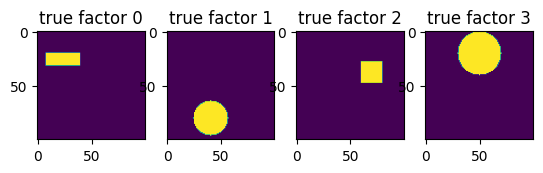

In [3]:
# Plot the factors
fig, axs = plt.subplots(1, num_factors)
for k in range(num_factors):
    axs[k].imshow(true_factors[k])
    axs[k].set_title("true factor {}".format(k))

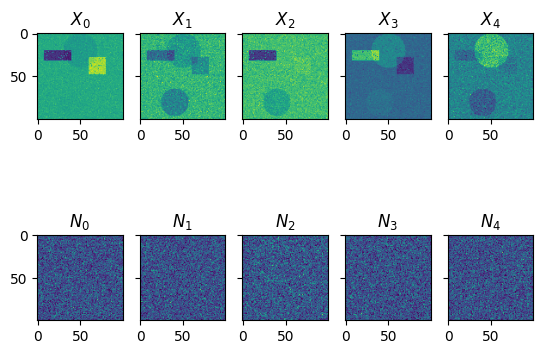

In [4]:
# Plot some of the data
fig, axs = plt.subplots(2, 5, sharey=True)
for m in jnp.arange(5):
    axs[0, m].imshow(data[m])
    axs[0, m].set_title(r"$X_{}$".format(m))
    axs[1, m].imshow(counts[m])
    axs[1, m].set_title(r"$N_{}$".format(m))

## Fit the model!

In [5]:
# Fit the model
losses, params = seminmf.fit_batch(data, 
        counts,
        4,
        loading_scale=loading_scale,
        num_iters=500,
        initialization="greedy",
        stepsize=1e-1,
        dpp_prior_scale=1e4,
        verbosity=0,
        )

  0%|          | 0/500 [00:00<?, ?it/s]

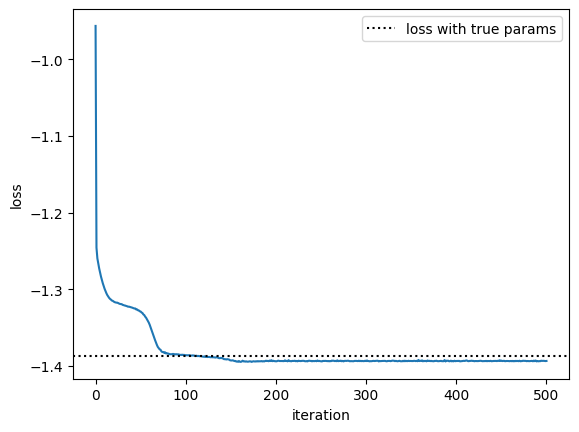

In [6]:
# Plot the losses
plt.figure()
plt.plot(losses)
plt.axhline(seminmf.compute_loss(data, counts, true_params),
            ls=':', color='k', label='loss with true params')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

In [7]:
from scipy.optimize import linear_sum_assignment
from dataclasses import replace

def find_permutation(factors, true_factors):
    """
    Find the permutation of the inferred factors so that they best align
    with the true factors

    Returns:
        permutation such that ``jnp.take(perm, factors)`` best aligns with ``true_factors``.
        
    """
    overlap = jnp.einsum('k...,j...->kj', true_factors, factors) 
    _, perm = linear_sum_assignment(-overlap)
    unused = set(range(len(factors))) - set(perm)
    if len(unused) > 0:
        return jnp.concatenate([perm, jnp.array(list(unused))])
    else:
        return perm

perm = find_permutation(params.factors, true_factors)
perm_factors = jnp.take(params.factors, perm, axis=0)
perm_loadings = jnp.take(params.loadings, perm, axis=1)
params = replace(params, factors=perm_factors, loadings=perm_loadings)

Array([145.00038, 160.12299, 147.67426, 136.56387], dtype=float32)

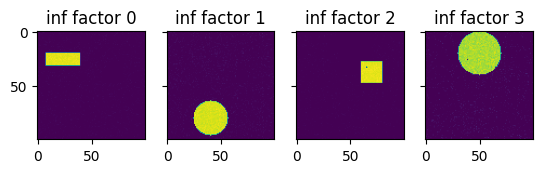

In [8]:
fig, axs = plt.subplots(1, params.num_factors, sharey=True)
for k in range(params.num_factors):
    axs[k].imshow(params.factors[k], vmin=-0)
    axs[k].set_title("inf factor {}".format(k))

params.loadings.std(axis=0)

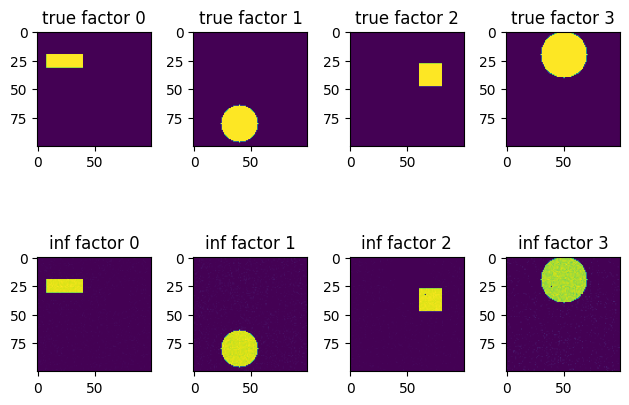

In [9]:
# Plot the factors
fig, axs = plt.subplots(2, num_factors)
for k in range(num_factors):
    try: 
        axs[0, k].imshow(true_factors[k], vmin=-0)
        axs[0, k].set_title("true factor {}".format(k))
    except:
        pass

    axs[1, k].imshow(params.factors[k], vmin=-0)
    axs[1, k].set_title("inf factor {}".format(k))
plt.tight_layout()

(21.0, -1.0)

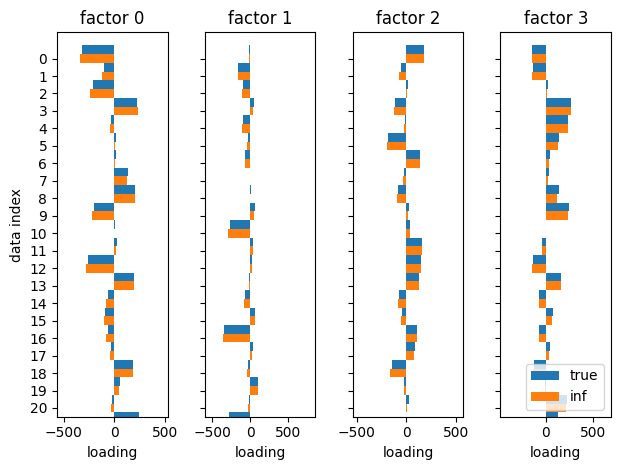

In [14]:
# Plot the loadings
fig, axs = plt.subplots(1, num_factors, sharey=True)
for k in range(num_factors):
    axs[k].barh(jnp.arange(num_mice), true_loadings[:, k], height=0.5, label='true')
    axs[k].barh(jnp.arange(num_mice)+.5, params.loadings[:, k], height=0.5, label='inf')
    axs[k].set_title("factor {}".format(k))
    axs[k].set_yticks(jnp.arange(num_mice) + .5)
    axs[k].set_yticklabels(jnp.arange(num_mice))
    axs[k].set_xlabel("loading")
    
    if k == 0:
        axs[k].set_ylabel("data index")
        
    if k == num_factors - 1:
        axs[k].legend(loc="lower right")

        plt.tight_layout()

plt.ylim(21, -1)

0.010000000000000002


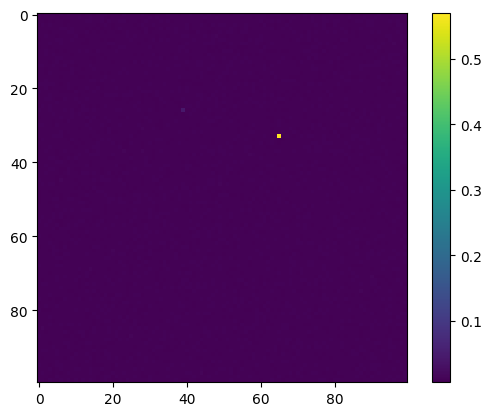

In [15]:
plt.imshow(params.emission_noise_var)
plt.colorbar()
print(true_emission_noise_var)

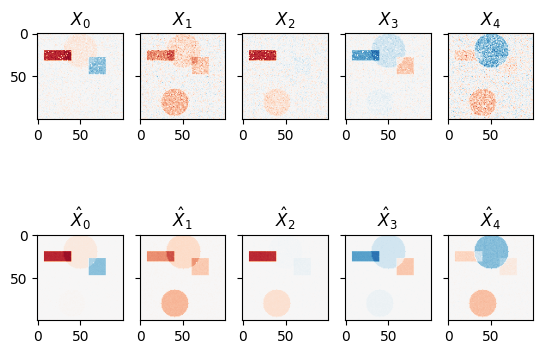

In [12]:
# Plot data and reconstructions
fig, axs = plt.subplots(2, 5, sharey=True)
reconstruction = seminmf.compute_mean(params)
for m in range(5):
    vmax = abs(data[m]).max()
    axs[0, m].imshow(data[m], vmin=-vmax, vmax=vmax, cmap="RdBu")
    axs[0, m].set_title(r"$X_{}$".format(m))
    
    axs[1, m].imshow(reconstruction[m], vmin=-vmax, vmax=vmax, cmap="RdBu")
    axs[1, m].set_title(r"$\hat{{X}}_{}$".format(m))

## Conclusion

It's working for this super simple example! 
